In [1]:
import pandas as pd
import os
import sys
sys.path.append('../')
from utils import *
from fears.utils import AutoRate
import seaborn as sns
import calibration_08302023 as cal

rfu30_to_dilution = cal.run()

folder_path = '../data/in_vitro_dosing'

exp_info = {'pefect':['B2','B3','B4','B5','B6','B7','B8','B9','B10','B11'],
            'early_nadh':['C2','C3','C4','C5','C6','C7','C8','C9','C10','C11'],
            'late_adh':['D2','D3','D4','D5','D6','D7','D8','D9','D10','D11'],
            'control':['F2','F3','F4','F5','F6','F7','F8','F9','F10','F11']}

In [2]:
files = os.listdir(folder_path)
files = [f for f in files if f.endswith('.xlsx')]

# filter out temp files
files = [f for f in files if not f.startswith('~')]

files.sort(key=natural_keys)

data=[]

for file in files:
    filepath = os.path.join(folder_path, file)

    p = AutoRate.Plate(filepath,mode='single_measurement')

    data.append(p.od_data_to_dict(p.data))

In [3]:
control_row = 'F'
data_cell_count = []

for i, d in enumerate(data):
    data_t = {}
    for row in ['B','C','D']:
        for col in range(2,12):
            bg_well = control_row + str(col)
            bg_cell_count = rfu30_to_dilution(d[bg_well], background_subtracted=True)
            data_t[bg_well] = bg_cell_count

            cell_count = rfu30_to_dilution(d[row + str(col)], background_subtracted=True)
            data_t[row + str(col)] = cell_count - bg_cell_count
    
    data_cell_count.append(data_t)
    

In [4]:
d = data_cell_count[2]

print(d['F2'])
print(d['D2'])

199.00210928259798
58.67778216049601


In [5]:
df = pd.DataFrame(columns=['condition','well','time','value'])

time = 0
index = 0

for d in data_cell_count:
    for condition in exp_info.keys():
        for well in exp_info[condition]:
            if well[0] == 'F':
                continue
            # add a row to df using concat
            df = pd.concat([df,pd.DataFrame({'condition':condition,
                                             'well':well,
                                             'time':time,
                                             'value':d[well]},index=[index])])
            index += 1
    time += 1

df

,condition,well,time,value
0,pefect,B2,0,4285.713345
1,pefect,B3,0,6537.576304
2,pefect,B4,0,2880.856085
3,pefect,B5,0,1834.366472
4,pefect,B6,0,2159.567704
...,...,...,...,...
85,late_adh,D7,2,67.622762
86,late_adh,D8,2,72.935541
87,late_adh,D9,2,59.310352
88,late_adh,D10,2,64.529683


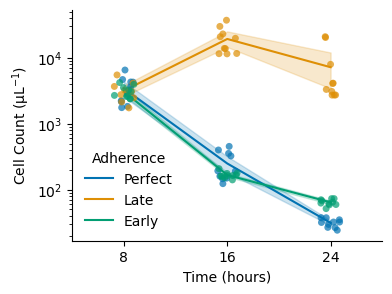

In [6]:
fig,ax = plt.subplots(figsize=(4,3))

palette = 'colorblind'

sns.lineplot(data=df,x='time',y='value',hue='condition',ax=ax,palette=palette)
sns.stripplot(data=df,x='time',y='value',hue='condition',ax=ax,alpha=0.7,palette=palette)
# sns.boxplot(data=df,x='time',y='value',hue='condition',ax=ax)

ax.set_yscale('log')

ax.set_xticks([0,1,2])
ax.set_xticklabels(['8','16','24'])

# get legend handles and labels
handles, labels = ax.get_legend_handles_labels()
labels = ['Perfect','Late','Early']
handles = handles[0:3]

# reorder handles and labels to perfect, early, late
# handles = [handles[1],handles[0],handles[2]]
# labels = [labels[1],labels[0],labels[2]]

ax.legend(handles=handles, labels=labels,frameon=False,title='Adherence')

ax.set_xlabel('Time (hours)')
ax.set_ylabel('Cell Count ' +  r'$(\mathrm{\mu L} ^{-1})$')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig('../figures/in_vitro_dosing.png',dpi=500,bbox_inches='tight',
            transparent=True)

fig.savefig('../figures/in_vitro_dosing.pdf',bbox_inches='tight',
            transparent=True)